# Step 1: Import Libraries and Generate Synthetic Data

In [1]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:

# Generate synthetic data
x_numpy = np.random.uniform(-3, 3, (1000, 3))
y_numpy = np.sin(x_numpy[:, 0]) + x_numpy[:, 1]**2 - np.log(1 + np.abs(x_numpy[:, 2])) + np.random.normal(0, 0.1, x_numpy.shape[0])
y_numpy = y_numpy.reshape(-1, 1)  # Reshape y to match output dimensions

# Convert numpy arrays to torch tensors
x = torch.tensor(x_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy, dtype=torch.float32)

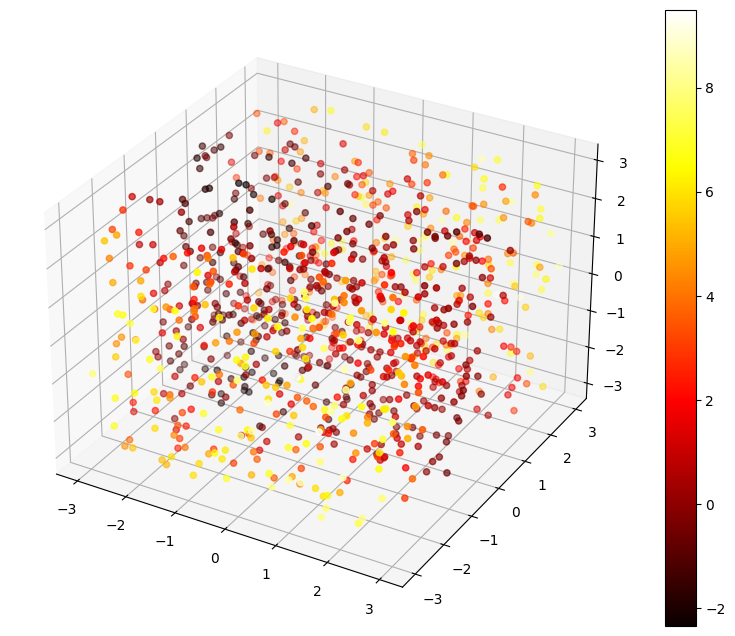

In [4]:
# Function to plot 4D data
def plot_4d(x, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.squeeze(), cmap=plt.hot())
    fig.colorbar(p)
    plt.show()

# Plotting the synthetic data
plot_4d(x_numpy, y_numpy)


# Step 2: Define the Neural Network

In [12]:
class ThreeLayerNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ThreeLayerNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases as nn.Parameter
        self.W1 = torch.nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.b1 = torch.nn.Parameter(torch.zeros(hidden_size))
        self.W2 = torch.nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b2 = torch.nn.Parameter(torch.zeros(hidden_size))
        self.W3 = torch.nn.Parameter(torch.randn(hidden_size, output_size) * 0.1)
        self.b3 = torch.nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        # Forward pass using einsum for matrix multiplication
        z1 = torch.einsum('ij,jk->ik', x, self.W1) + self.b1
        a1 = torch.relu(z1)
        z2 = torch.einsum('ij,jk->ik', a1, self.W2) + self.b2
        a2 = torch.relu(z2)
        z3 = torch.einsum('ij,jk->ik', a2, self.W3) + self.b3
        return z3


In [13]:
torch.cuda.is_available()

True

# Step 3: Training the Model

Epoch 0, Loss: 13.702381134033203
Epoch 100, Loss: 0.10819998383522034
Epoch 200, Loss: 0.045129235833883286
Epoch 300, Loss: 0.033798813819885254
Epoch 400, Loss: 0.02776551991701126
Epoch 500, Loss: 0.02426474541425705
Epoch 600, Loss: 0.02185622602701187
Epoch 700, Loss: 0.017658984288573265
Epoch 800, Loss: 0.015699155628681183
Epoch 900, Loss: 0.014164488762617111


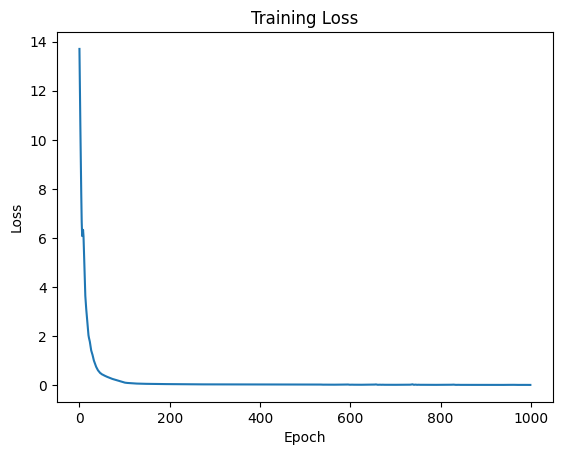

In [14]:
# Hyperparameters
learning_rate = 0.01
epochs = 1000

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model instantiation and moving model to the appropriate device
model = ThreeLayerNN(3, 64, 1)
model.to(device)  # Ensure the model is on the same device as the data

# Continue as before
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([model.W1, model.b1, model.W2, model.b2, model.W3, model.b3], lr=learning_rate)

# Ensure data is on the correct device
x, y = x.to(device), y.to(device)


# Training loop
losses = []
for epoch in range(epochs):
    # Forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)
    losses.append(loss.item())

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plot training loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Step 4: Visualization of Predicted vs. Actual

In [16]:
# Predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model(x).cpu().numpy()

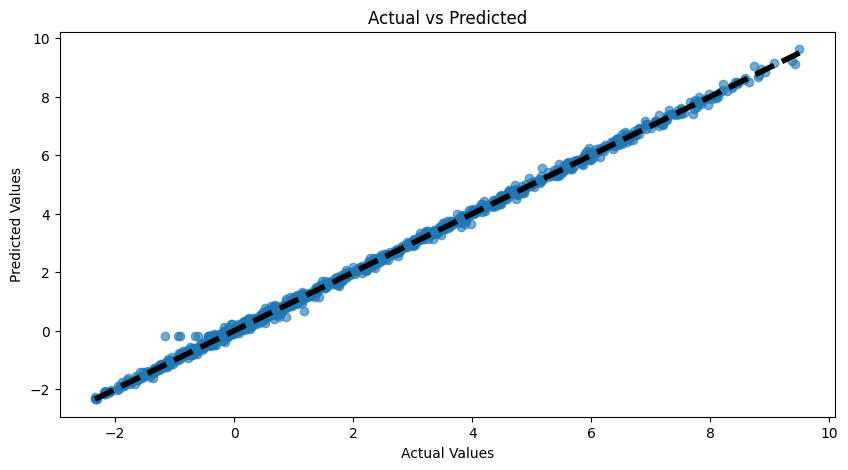

In [17]:
# Ensure y is on CPU and convert to numpy for min/max calculations
y_cpu = y.cpu().numpy()

# Now you can safely find min and max for plotting
y_min, y_max = y_cpu.min(), y_cpu.max()

# Actual vs Predicted plot
plt.figure(figsize=(10, 5))
plt.scatter(y_cpu, y_pred, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y_min, y_max], [y_min, y_max], 'k--', lw=4)  # Line for perfect predictions
plt.show()
